## Compare Spectra for each case with the theoretical, predicted spectra

In [1]:
import tqdm
import time
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


import sys
stormtrack = 1
if stormtrack == 0:
    usr = "gliu"
    datpath = "/Users/%s/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/01_Data/model_input/" % usr
    sys.path.append("/Users/%s/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/03_Scripts/stochmod/model/"% usr)
    sys.path.append("/Users/%s/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/"% usr)
elif stormtrack == 1: # NOTE... need to edit this
    datpath = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/HMXL/"
    sys.path.append("/home/glliu/00_Scripts/01_Projects/00_Commons/")
    sys.path.append("/home/glliu/00_Scripts/01_Projects/01_AMV/02_stochmod/stochmod/model/")

import scm
from amv import proc,viz
import tbx

In [2]:
# Paths, User Inputs
outpath = "/stormtrack/data3/glliu/02_Figures/20210715/"
datpath = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/NHFLX/"
"""
-rw-rw-r-- 1 glliu glliu 4.5G Apr 25 17:37 NHFLX_PIC_Full.npy
-rw-rw-r-- 1 glliu glliu 1.9G Feb  2 22:57 NHFLX_PIC.nc
-rw-rw-r-- 1 glliu glliu 1.8G Feb 19 01:18 NHFLX_PIC_SLAB_raw.nc
-rw-rw-r-- 1 glliu glliu 1.3G Feb 19 02:09 TS_PIC_SLAB_raw.nc
"""


#datpath = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/01_hfdamping/hfdamping_PIC_SLAB/02_ENSOREM/"

"""
-rw-rw-r-- 1 glliu glliu 2.3G Nov 15  2020 ENSOREM_TS_lag1_pcs2_monwin3.npz
-rw-rw-r-- 1 glliu glliu 2.3G Mar 19 04:19 ENSOREM_NHFLX_lag1_pcs2_monwin3.npy
"""


# Constants
rho   = 1026
cp0   = 3996
hmean = 54.61088498433431 # from SLAB_PIC_hblt.npy
mons3 = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
mldmode = "Const"

# Load Latlon
datpath2 = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Model_Data/model_input/"

# Load lat/lon
from scipy.io import loadmat
mt = loadmat("/home/glliu/01_Data/CESM1_LATLON.mat")
lat = mt["LAT"].squeeze()#np.load(datpath2+"../lat.npy")
lon36 = mt["LON"].squeeze()#np.load(datpath2+"../lon.npy")
lon,_ = proc.lon360to180(lon36,np.ones((288,192,1)))


lonf = -30
latf = 50
klon,klat = proc.find_latlon(lonf,latf,lon,lat)

Closest lon to -30.00 was -30.00
Closest lat to 50.00 was 50.42


## Load SST, NHFLX

In [3]:
%%time

# Load SST from SLAB

ds   = xr.open_dataset(datpath+"TS_PIC_SLAB_raw.nc")
dspt = ds.sel(lon=330,lat=50,method='nearest')
T   = dspt.TS.values
dspt

CPU times: user 314 ms, sys: 22.8 ms, total: 336 ms
Wall time: 334 ms


<xarray.Dataset>
Dimensions:  (time: 10812)
Coordinates:
    lev      float64 ...
    lat      float64 50.42
    lon      float64 330.0
  * time     (time) object 0101-02-01 00:00:00 ... 1002-01-01 00:00:00
Data variables:
    TS       (time) float32 282.09058 280.616 280.64438 ... 284.21448 283.3534
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             e.e11.E1850C5CN.f09_g16.001
    title:            UNSET
    logname:          adrianne
    host:             ys0222
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /glade/p/cesmdata/cseg/inputdata/atm/cam/inic/fv/cami-m...
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...

In [4]:
%%time 
# Load NHFLX from SLAB

ds   = xr.open_dataset(datpath+"NHFLX_PIC_SLAB_raw.nc")
dspt = ds.sel(lon=330,lat=50,method='nearest')
Q  = dspt.NHFLX.values

# Get # of Years
ntime = Q.shape[0]
nyr   = int(ntime/12)

dspt

CPU times: user 354 ms, sys: 19.9 ms, total: 374 ms
Wall time: 372 ms


<xarray.Dataset>
Dimensions:  (time: 10812)
Coordinates:
    lev      float64 ...
    lat      float64 50.42
    lon      float64 330.0
  * time     (time) object 0101-01-01 00:00:00 ... 1001-12-01 00:00:00
Data variables:
    NHFLX    (time) float32 -245.63795 -158.8689 ... -121.01072 -190.09209

Closest lon to 330.00 was 330.00
Closest lat to 50.00 was 50.42
CPU times: user 61.8 ms, sys: 2.66 s, total: 2.72 s
Wall time: 2.72 s


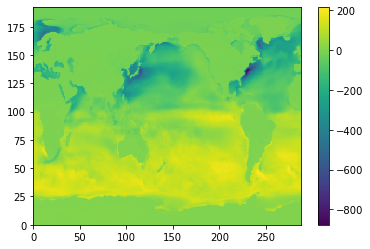

In [5]:
%%time
# Load in data for Qnet, CESM-FULL
Qfull   = np.load(datpath+"NHFLX_PIC_Full.npy")

klon360,_ = proc.find_latlon(lonf+360,latf,lon36,lat)
Qfull.shape, plt.pcolormesh(Qfull[0,0,:,:]),plt.colorbar()

Qfullpt  = Qfull[:,:,klat,klon360]

Qafullpt = Qfullpt - Qfullpt.mean(0)[None,:]


In [6]:
%%time

# Remove monthly anomalies

# Preallocate
v_in  = [T,Q,Qfullpt.flatten()]
v_a   = []
for v in v_in:
    
    v  = v.reshape(int(v.shape[0]/12),12)
    va = v - v.mean(0)[None,:]
    v_a.append(va.flatten())

Ta,Qa,Qafull = v_a


CPU times: user 1.61 ms, sys: 1.62 ms, total: 3.23 ms
Wall time: 1.52 ms


CPU times: user 20.7 ms, sys: 4.65 ms, total: 25.4 ms
Wall time: 22.6 ms


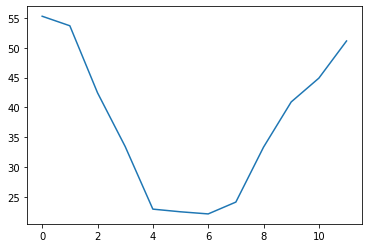

In [7]:
%%time

# Load forcing amplitude
alpha_all = np.load(datpath2+"SLAB_PIC_NHFLXSTD_Forcing_MON.npy")
alpha_all.shape
alpha = alpha_all[klon,klat,:]
plt.plot(alpha)

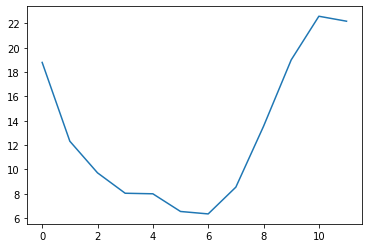

In [8]:
# Load damping

lbd_all = np.load(datpath2+"SLAB_PIC_NHFLX_Damping_monwin3_sig005_dof894_mode4.npy")
lbd     = lbd_all[klon,klat,:]
#plt.pcolormesh(lbd_all[:,:,0].T),lbd
plt.plot(lbd)

In [9]:
# Load Mixed Layer Depth
if mldmode == "Const":
    mld = np.ones(12)*hmean
else:
    mld_all = np.load(datpath2+"HMXL_hclim.npy")
    mld     = mld_all[klon,klat,:]
    plt.plot(mld)

# Convert Lambda from W/m2/degC to 1/sec, make forcing

In [10]:
# Take average lambda and convert to 1/sec
# Calculate stochastic timeseries

#lbd_avg = lbd.mean()
lbd_mon = lbd/(rho*cp0*mld)
lbd_pt  = lbd
lbd_avg = lbd_pt.mean() / (rho*cp0*mld.mean())
lbd_winter = (lbd_pt[[1,11,0]] / (rho*cp0*mld[[1,11,0]])).mean()
lbd_summer = (lbd_pt[[5,6,7]] / (rho*cp0*mld[[5,6,7]])).mean()


randts  = np.random.normal(0,1,ntime)
q_mon   = randts * np.tile(alpha,int(Qa.shape[0]/12))
q_avg   = randts * alpha.mean()



print("lbd_avg^-1 is %.3f months" % (1/(lbd_avg*3600*24*30)))
print("lbd_winter^-1 is %.3f months" % (1/(lbd_winter*3600*24*30)))
print("lbd_summer^-1 is %.3f months" % (1/(lbd_summer*3600*24*30)))

lbd_avg^-1 is 6.661 months
lbd_winter^-1 is 4.862 months
lbd_summer^-1 is 12.100 months


In [11]:
lbd_pt[[5,6,7]] / (rho*cp0*mld[[5,6,7]])

array([2.92015627e-08, 2.83059788e-08, 3.81440040e-08])

In [12]:
print((1/(lbd_mon*3600*24*30)))

[ 4.59535335  7.01316792  8.88990129 10.74702782 10.80716455 13.21170629
 13.62971658 10.11436735  6.37880799  4.54520088  3.82282305  3.89318639]


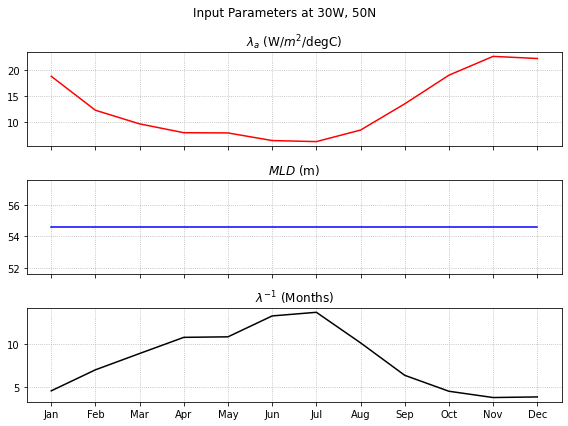

In [13]:
fig,axs= plt.subplots(3,1,sharex=True,figsize=(8,6))


ax = axs[0]
ax.plot(mons3,lbd,color='red')
ax.grid(True,ls='dotted')
ax.set_title("$\lambda_a$ (W/$m^{2}$/degC)")

ax = axs[1]
ax.plot(mons3,mld,color='blue')
ax.set_title("$MLD$ (m)")
ax.grid(True,ls='dotted')

ax = axs[2]
ax.plot(mons3,1/(lbd_mon*3600*24*30),color='k')
ax.set_title("$\lambda^{-1}$ (Months)")
ax.grid(True,ls='dotted')

plt.suptitle("Input Parameters at 30W, 50N")
plt.tight_layout()

plt.savefig("%sDamping_Monthly_Timescales_30W50N.png"%outpath,dpi=200)

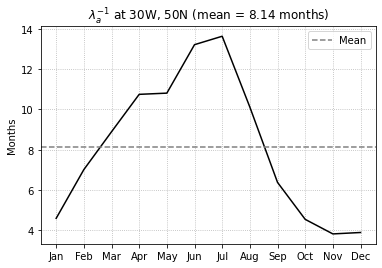

In [14]:

# Underestimation
# Plot just the timescale
fig,ax = plt.subplots(1,1)
ax.plot(mons3,1/(lbd_mon*3600*24*30),color='k')
ax.set_title("$\lambda_a^{-1}$ at 30W, 50N (mean = %.2f months)" % (np.mean(1/(lbd_mon*3600*24*30))))
ax.axhline(np.mean(1/(lbd_mon*3600*24*30)),color='gray',ls='dashed',label="Mean")
ax.legend()
ax.set_ylabel("Months")
ax.grid(True,ls='dotted')
plt.savefig("%sDecay_Timescale_30W50N.png"%outpath,dpi=200)



In [76]:
#1/(lbd_pt[[10,11,0]]/(rho*cp0*mld[[10,11,0]]*3600*24*30))

## Brief Section to Recreate values from Claude's Document

In [77]:
# Recreate Claude's estimate of correlation b/w q and T given some monthly average
nmons   = 10
ndays   = 5
lbdtest = 1 / (24*3600*30*nmons)
nutest  = 1 / (24*3600*ndays)
t_avg   = 24*3600*30

corrc   = ( (lbdtest * nutest * t_avg**2) / (2*(nutest*t_avg-1)) )**.5
corrc


def calc_Tqcorr(nmons,ndays,dayinmon=30):
    """
    From Frankignoul and Hasselmann (1977, Eq. A7), estimate the correlation between T and q
    after averaging for a given monthly timescale, given...

    Inputs
    ------
        1. nmons NUMERIC : # of months for long timescale lambda
        2. ndays NUMERIC : # of months for short timescale nu
        3. dayinmon INT (optional) : Number of days in the month
        
    Returns corr(T,q)
    """
    # Timescales
    lbdtest = 1/(24*3600*dayinmon*nmons) # Month Timescale
    nutest  = 1/(24*3600*ndays) # Day timescale
    t_avg   = 24*3600*dayinmon
    return ( (lbdtest * nutest * t_avg**2) / (2*(nutest*t_avg-1)) )**.5
    

calc_Tqcorr(10,5),corrc


(0.2449489742783178, 0.2449489742783178)

In [78]:
# Calculate some intermediate coefficients

C = lbdtest*t_avg*2*corrc # Coefficient multiplying (var_q*var_t)^0.5
B = (lbdtest*t_avg)**2

B,C

(0.010000000000000002, 0.048989794855663564)

In [79]:
# Calculate coefficients relating to var(T), var(q)

A1   = np.exp(-lbdtest*t_avg)
A2   = (1-np.exp(-lbdtest*t_avg))/(lbdtest*t_avg)

A1,A2

(0.9048374180359595, 0.9516258196404048)

In [80]:
# Use above coefficients to calculate the variance

# Square coeffiicent for q-tilde and divide by squared coefficient for T
A = (A2**2) / (1-np.exp(-2*lbdtest*t_avg))

A # Number appears to be slightly larger?
#

4.995837495788002

In [81]:
# Return to original equation, plugging in var(T)


Bfin = A*B
Cfin = A**.5*C

Bfin,Cfin

(0.049958374957880025, 0.10949890405794574)

In [82]:
# Calculate underestimation of q

1 + (Bfin-Cfin)

0.9404594708999343

In [83]:
# Make the above into a function

def calc_underestq(lbdtest,corrc,t_avg):
    """
    Based on Claude's note, calculate the underestimation of
    stochastic forcing based on taking monthly averages from CESM
    Inputs
    lbdtest : damping timescale in 1/sec
    corrc   : coefficient of corr(T,q)
    t_avg   : conversion timestep in seconds
    
    """
    # First 2 coefficients
    C = lbdtest*t_avg*2*corrc # Coefficient multiplying (var_q*var_t)^0.5
    B = (lbdtest*t_avg)**2    # Coefficient multiplying var(T)
    
    
    # Calculate coefficients relating to T, q from integration
    A1   = np.exp(-lbdtest*t_avg)
    A2   = (1-np.exp(-lbdtest*t_avg))/(lbdtest*t_avg)

    # Calculate var(T) coefficient (taking var of discretized eqn)
    A = (A2**2) / (1-np.exp(-2*lbdtest*t_avg))

    # Plug in var(T) to original coefficients
    Bfin = A*B
    Cfin = A**.5*C
    
    # Sum coefficients of q 
    underest = 1 + (Bfin-Cfin)
    
    return underest

calc_underestq(lbdtest,corrc,t_avg)

0.9404594708999343

Values seem to check out... next test things at a point

## Test Function with Lambda values at the point

Try calculating the understimation of $F_{QQ}$ in the stochastic model

In [15]:

lbd_mon_conv = 1/(lbd_mon*3600*24*30) # Convert timescales to months
corrc        = calc_Tqcorr(lbd_mon_conv,ndays,dayinmon=30)
underest     = calc_underestq(lbd_mon,corrc,t_avg)




NameError: name 'calc_Tqcorr' is not defined

NameError: name 'underest' is not defined

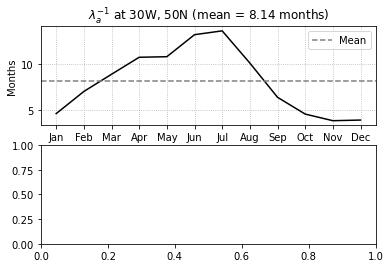

In [16]:
# Plot Results

# Underestimation
# Plot just the timescale
fig,axs = plt.subplots(2,1)

ax = axs[0]
ax.plot(mons3,1/(lbd_mon*3600*24*30),color='k')
ax.set_title("$\lambda_a^{-1}$ at 30W, 50N (mean = %.2f months)" % (np.mean(1/(lbd_mon*3600*24*30))))
ax.axhline(np.mean(1/(lbd_mon*3600*24*30)),color='gray',ls='dashed',label="Mean")
ax.legend()
ax.set_ylabel("Months")
ax.grid(True,ls='dotted')
plt.savefig("%sDecay_Timescale_30W50N.png"%outpath,dpi=200)

ax = axs[1]
ax.bar(mons3,(1-underest)*100,color='orange')
ax.set_title("Underestimation of var(Q) at 30W, 50N (mean = %.2f)" % ((1-np.mean(underest))*100)+"%")
ax.axhline((1-np.mean(underest))*100,color='black',ls='dashed',label="Mean")
ax.set_ylim([0,20])
ax.set_yticks(np.arange(0,22.5,2.5))
ax.legend()
ax.set_ylabel("% Underestimate")
ax.grid(True,ls='dotted')
plt.tight_layout()
plt.savefig("%sDecay_Timescale_30W50N_mldomde%s.png"% (outpath,mldmode),dpi=200)


In [88]:
lbd_mon

array([8.39549083e-08, 5.50111552e-08, 4.33978350e-08, 3.58985271e-08,
       3.56987688e-08, 2.92015627e-08, 2.83059788e-08, 3.81440040e-08,
       6.04819066e-08, 8.48812801e-08, 1.00920829e-07, 9.90968401e-08])

# $F_{QQ}$ of CESM SLAB vs. FULL

In [17]:
# Calculate the spectra
nsmooth = [250,250,250]
pct     = 0.10

specs,freqs,CCs,dofs,r1s = scm.quick_spectrum(v_a,nsmooth,pct)

Warning, window does not sum to 1!
Warning, window does not sum to 1!
Warning, window does not sum to 1!


In [18]:
# Calculate Confidence Interval



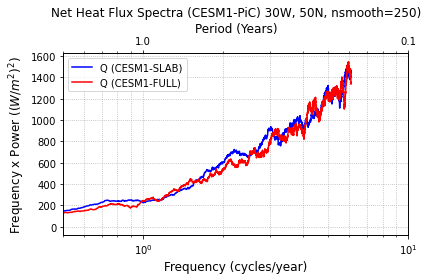

In [19]:
# Plot the spectra comparing slab and full heat fluxes(from analysis/plot_spectra_Generals.py)

# Plotting Params
plotdt = 3600*24*365
xtick  = [float(10)**(x) for x in np.arange(-4,2)]
#ylm    = [-.01,.5]
xlm    = [5e-1,10]
titles = ("Varying Damping and Forcing (Levels 1-3)",
          "Varying Mixed-Layer Depth (Levels 3-5)")
plotconf=False

# Plotting params (SPECIFIC TO THIS SCRIPT)
nplot=len(freqs)
ecolors = ["gray","blue","red"]
enames = ["T","Q (CESM1-SLAB)","Q (CESM1-FULL)"]

fig,ax = plt.subplots(1,1,figsize=(6,4))
  
for n in [1,2]:
    ax.semilogx(freqs[n]*plotdt,specs[n]*freqs[n],color=ecolors[n],label=enames[n])

if plotconf:
    ax.semilogx(freqs[n]*plotdt,CCs[n][:,1]*freqs[n],color=ecolors[n],alpha=0.5,ls='dashed')
    ax.semilogx(freqs[n]*plotdt,CCs[n][:,0]*freqs[n],color=ecolors[n],alpha=0.5,ls='dotted')

# Set Labels
ax.set_ylabel("Frequency x Power ($(W/m^2)^{2}$)",fontsize=12)
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)
htax = viz.twin_freqaxis(ax,freqs[1],"Years",plotdt,mode='log-lin',xtick=xtick)

# Set upper x-axis ticks
xtick2 = htax.get_xticks()
xtkl = ["%.1f" % (1/x) for x in xtick2]
htax.set_xticklabels(xtkl)
    
# Set axis limits
ax.set_xlim(xlm)
htax.set_xlim(xlm)
#ax.set_ylim(ylm)
#htax.set_ylim(ylm)
    
ax.legend(fontsize=10)
#ax.set_title(titles[i])
    
locstring= "30W, 50N"
ax.set_title("Net Heat Flux Spectra (CESM1-PiC) %s, nsmooth=%i)"%(locstring,nsmooth[1]))
ax.grid(True,which='both',ls='dotted')
plt.tight_layout()


plt.savefig("%sNHFLX_Spectra_Comparison_CESM-PIC_nsmooth%i_lon-30_lat50_Ann.png"%(outpath,nsmooth[1]),dpi=200)

# Investigate difference between theoretical spectra and CESM-SLAB $F_{QQ}$

In [74]:
# calculate spectra for other things
nsm = 500
nsmooth = np.ones(5)*nsm
taper   = 0.1

specs,freqs,CCs,dofs,r1s = scm.quick_spectrum([Ta,Qa,q_avg,q_mon,Qafull],nsmooth,pct)
 

Warning, window does not sum to 1!
Warning, window does not sum to 1!
Warning, window does not sum to 1!
Warning, window does not sum to 1!
Warning, window does not sum to 1!


In [75]:
# Calculate the Confidence Intervals
alpha = 0.05
bnds = []
for nu in dofs:
    lower,upper = tbx.confid(alpha,nu*2)
    bnds.append([lower,upper])
dofs

[948.7161972418921,
 948.7161972418921,
 948.7161972418921,
 948.7161972418921,
 948.7161972418921]

In [76]:
# Print the variance of each timeseries
cesmvarn = ["T'","Q'","$q_{const}'$","$q_{vary}''$","Q (CESM-FULL)"]
cesmvars = [Ta,Qa,q_avg,q_mon,Qafull]
for v in range(len(cesmvars)):
    print("Variance(%s) is %f" % (cesmvarn[v],np.var(cesmvars[v])))

Variance(T') is 0.929725
Variance(Q') is 1531.833374
Variance($q_{const}'$) is 1427.402219
Variance($q_{vary}''$) is 1572.921666
Variance(Q (CESM-FULL)) is 1553.868164


In [ ]:
# Calculate Theoretical

Fqq0 = specs[2][0] # Take value of Fqq at zero

#Fqq0 = specs[1][0]
omega = freqs[0]

# Theoretical F_QQ, smooth estimate, assuming white noise
Qth     = Fqq0 * (omega**2 / (omega**2+lbd_avg**2))

# F_QQ estimated with seasonal mean parameters
Qth_avg = specs[2] * (omega**2 / (omega**2+lbd_avg**2))

# F_QQ estimated with monthly varying parameters
Qth_mon = specs[3] * (omega**2 / (omega**2+lbd_avg**2))

# Other
#QthQQ = (Fqq0+(1-underest.max())*Fqq0) * (omega**2 / (omega**2+lbd_avg**2)) # Rescale by 6% to re-estimate the values
Qth_winter = Fqq0 * (omega**2 / (omega**2+lbd_winter**2))
Qth_summer = Fqq0 * (omega**2 / (omega**2+lbd_summer**2))


In [99]:
underest.max()

NameError: name 'underest' is not defined

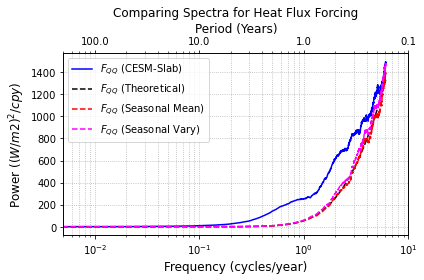

In [23]:
# Plot the spectra (from analysis/plot_spectra_Generals.py)
# Plotting Params
plotdt = 3600*24*365
xtick  = [float(10)**(x) for x in np.arange(-4,2)]
#ylm    = [-.01,.5]
xlm    = [5e-3,10]
titles = ("Varying Damping and Forcing (Levels 1-3)",
          "Varying Mixed-Layer Depth (Levels 3-5)")
plotconf=False


# Plotting params (SPECIFIC TO THIS SCRIPT)
nplot=len(freqs)
ecolors = ["gray","blue","orange","cyan"]
enames = ["T","$F_{QQ}$ (CESM-Slab)","$F_{qq}$ (Applied, Const)","$F_{qq}$ (Applied, Vary)"]

fig,ax = plt.subplots(1,1,figsize=(6,4))
  
for n in [1]:
    ax.semilogx(freqs[n]*plotdt,specs[n]*freqs[n],color=ecolors[n],label=enames[n])

if plotconf:
    ax.semilogx(freqs[n]*plotdt,CCs[n][:,1]*freqs[n],color=ecolors[n],alpha=0.5,ls='dashed')
    ax.semilogx(freqs[n]*plotdt,CCs[n][:,0]*freqs[n],color=ecolors[n],alpha=0.5,ls='dotted')
    
ax.semilogx(omega*plotdt,Qth*omega,color="k",ls='dashed',label="$F_{QQ}$ (Theoretical)")
#ax.semilogx(omega*plotdt,QthQQ*omega,color="red",ls='solid',label="%.3f $F_{QQ}$ (Theoretical)" % (underest.max()))
#ax.semilogx(omega*plotdt,Qth_winter*omega,color="red",ls='dashed',label="$F_{QQ}$ (Theoretical, Winter)") 
#ax.semilogx(omega*plotdt,Qth_summer*omega,color="magenta",ls='dashed',label="$F_{QQ}$ (Theoretical, Summer)") 
ax.semilogx(omega*plotdt,Qth_avg*omega,color="r",ls='dashed',label="$F_{QQ}$ (Seasonal Mean)")
ax.semilogx(omega*plotdt,Qth_mon*omega,color="magenta",ls='dashed',label="$F_{QQ}$ (Seasonal Vary)")


# Set Labels
ax.set_ylabel("Power ($(W/m2)^{2} / cpy$)",fontsize=12)
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)
htax = viz.twin_freqaxis(ax,freqs[1],"Years",plotdt,mode='log-lin',xtick=xtick)

# Set upper x-axis ticks
xtick2 = htax.get_xticks()
xtkl = ["%.1f" % (1/x) for x in xtick2]
htax.set_xticklabels(xtkl)
    
# Set axis limits
ax.set_xlim(xlm)
htax.set_xlim(xlm)
# ax.set_ylim(ylm)
# htax.set_ylim(ylm)
    
ax.legend(fontsize=10)
#ax.set_title(titles[i])
    
locstring= "30W, 50N"
ax.set_title("Comparing Spectra for Heat Flux Forcing")
ax.grid(True,which='both',ls='dotted')
plt.tight_layout()


plt.savefig("%sNHFLX_Spectra_Theoretical_CESM-PIC_nsmooth%i_lon-30_lat50_Ann.png"%(outpath,nsmooth[1]),dpi=200)

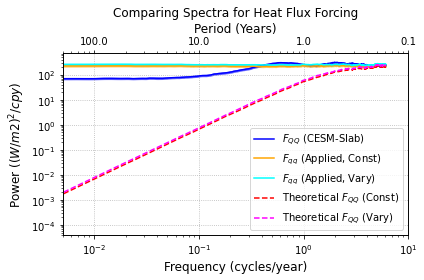

In [101]:
# Do a log-log plot

# Plot the spectra (from analysis/plot_spectra_Generals.py)

# Plotting Params
plotdt = 3600*24*365
xtick  = [float(10)**(x) for x in np.arange(-4,2)]
#ylm    = [-.01,.5]
xlm    = [5e-3,10]
titles = ("Varying Damping and Forcing (Levels 1-3)",
          "Varying Mixed-Layer Depth (Levels 3-5)")
plotconf=True

# Plotting params (SPECIFIC TO THIS SCRIPT)
nplot=len(freqs)
ecolors = ["gray","blue","orange","cyan"]
enames = ["T","$F_{QQ}$ (CESM-Slab)","$F_{qq}$ (Applied, Const)","$F_{qq}$ (Applied, Vary)"]

fig,ax = plt.subplots(1,1,figsize=(6,4))
  
for n in [1,2,3]:
    ax.loglog(freqs[n]*plotdt,specs[n]/plotdt,color=ecolors[n],label=enames[n])

if plotconf:
    for n in [1,2,3]:
        lower,upper = bnds[n]
        cobj = ax.fill_between(freqs[n]*plotdt,lower*specs[n]/plotdt,
                                       upper*specs[n]/plotdt,
                                       alpha=0.5,color=ecolors[n],
                                       label="")
    #ax.loglog(freqs[n]*plotdt,CCs[n][:,1]/plotdt,color=ecolors[n],alpha=0.5,ls='dashed')
    #ax.loglog(freqs[n]*plotdt,CCs[n][:,0]/plotdt,color=ecolors[n],alpha=0.5,ls='dotted')
    
#ax.loglog(omega*plotdt,Qth/plotdt,color="k",ls='dashed',label="$F_{QQ}$ (Theoretical)")
#ax.semilogx(omega*plotdt,QthQQ*omega,color="red",ls='solid',label="%.3f $F_{QQ}$ (Theoretical)" % (underest.max()))
#ax.semilogx(omega*plotdt,Qth_winter*omega,color="red",ls='dashed',label="$F_{QQ}$ (Theoretical, Winter)") 
#ax.semilogx(omega*plotdt,Qth_summer*omega,color="magenta",ls='dashed',label="$F_{QQ}$ (Theoretical, Summer)") 
ax.loglog(omega*plotdt,Qth_avg/plotdt,color="r",ls='dashed',label="Theoretical $F_{QQ}$ (Const)")
ax.loglog(omega*plotdt,Qth_mon/plotdt,color="magenta",ls='dashed',label="Theoretical $F_{QQ}$ (Vary)")


# Set Labels
ax.set_ylabel("Power ($(W/m2)^{2} / cpy$)",fontsize=12)
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)
htax = viz.twin_freqaxis(ax,freqs[1],"Years",plotdt,mode='log-log',xtick=xtick)

# Set upper x-axis ticks
xtick2 = htax.get_xticks()
xtkl = ["%.1f" % (1/x) for x in xtick2]
htax.set_xticklabels(xtkl)
    
# Set axis limits
ax.set_xlim(xlm)
htax.set_xlim(xlm)
# ax.set_ylim(ylm)
# htax.set_ylim(ylm)
    
ax.legend(fontsize=10)
#ax.set_title(titles[i])
    
locstring= "30W, 50N"
ax.set_title("Comparing Spectra for Heat Flux Forcing")
#ax.grid(True,which='both',ls='dotted')
plt.tight_layout()

plt.savefig("%sNHFLX_Spectra_Theoretical_CESM-PIC_nsmooth%i_lon-30_lat50_Ann_loglog.png"%(outpath,nsmooth[1]),dpi=200)


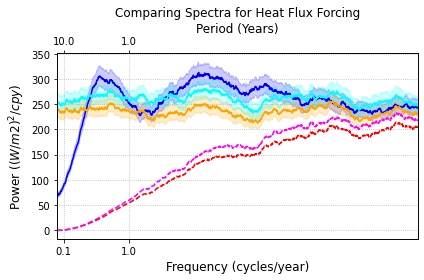

In [24]:
# Do a lin-lin plot

# Plot the spectra (from analysis/plot_spectra_Generals.py)

# Plotting Params
plotdt = 3600*24*365
xtick  = [1/10,1]
#ylm    = [-.01,.5]
xlm    = [5e-3,5]
titles = ("Varying Damping and Forcing (Levels 1-3)",
          "Varying Mixed-Layer Depth (Levels 3-5)")
plotconf=True

# Plotting params (SPECIFIC TO THIS SCRIPT)
nplot=len(freqs)
ecolors = ["gray","blue","orange","cyan"]
enames = ["T","$F_{QQ}$ (CESM-Slab)","$F_{qq}$ (Applied, Const)","$F_{qq}$ (Applied, Vary)"]

fig,ax = plt.subplots(1,1,figsize=(6,4))
  
for n in [1,2,3]:
    ax.plot(freqs[n]*plotdt,specs[n]/plotdt,color=ecolors[n],label=enames[n])

if plotconf:
    for n in [1,2,3]:
        lower,upper = bnds[n]
        cobj = ax.fill_between(freqs[n]*plotdt,lower*specs[n]/plotdt,
                                       upper*specs[n]/plotdt,
                                       alpha=0.20,color=ecolors[n],
                                       label="")
#     ax.plot(freqs[n]*plotdt,CCs[n][:,1]/plotdt,color=ecolors[n],alpha=0.5,ls='dashed')
#     ax.plot(freqs[n]*plotdt,CCs[n][:,0]/plotdt,color=ecolors[n],alpha=0.5,ls='dotted')
    
#ax.plot(omega*plotdt,Qth/plotdt,color="k",ls='dashed',label="$F_{QQ}$ (Theoretical)")
#ax.semilogx(omega*plotdt,QthQQ*omega,color="red",ls='solid',label="%.3f $F_{QQ}$ (Theoretical)" % (underest.max()))
#ax.semilogx(omega*plotdt,Qth_winter*omega,color="red",ls='dashed',label="$F_{QQ}$ (Theoretical, Winter)") 
#ax.semilogx(omega*plotdt,Qth_summer*omega,color="magenta",ls='dashed',label="$F_{QQ}$ (Theoretical, Summer)") 
ax.plot(omega*plotdt,Qth_avg/plotdt,color="r",ls='dashed',label="Theoretical $F_{QQ}$ (Const)")
ax.plot(omega*plotdt,Qth_mon/plotdt,color="magenta",ls='dashed',label="Theoretical $F_{QQ}$ (Vary)")


# Set Labels
ax.set_ylabel("Power ($(W/m2)^{2} / cpy$)",fontsize=12)
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)
htax = viz.twin_freqaxis(ax,freqs[1],"Years",plotdt,mode='lin-lin',xtick=xtick)

# Set upper x-axis ticks
xtick2 = htax.get_xticks()
xtkl = ["%.1f" % (1/x) for x in xtick2]
htax.set_xticklabels(xtkl)
    
# Set axis limits
ax.set_xlim(xlm)
htax.set_xlim(xlm)
# ax.set_ylim(ylm)
# htax.set_ylim(ylm)
    
#ax.legend(fontsize=10)
#ax.set_title(titles[i])
    
locstring= "30W, 50N"
ax.set_title("Comparing Spectra for Heat Flux Forcing")
ax.grid(True,which='both',ls='dotted')
plt.tight_layout()

plt.savefig("%sNHFLX_Spectra_Theoretical_CESM-PIC_nsmooth%i_lon-30_lat50_Ann_linlin.png"%(outpath,nsmooth[1]),dpi=200)


# Check how this compares with the full stochastic model terms


In [54]:
# Load in data from a clean run of synth_stochmod_spectra, with each separate term pulled out, of the sam
# length as the CESM1-SLAB run
stormtrack = 1
model = 1 # 0: h = 50m, 1: h = mean, 2: h=seasonal cycle, 3: h=entrain


if stormtrack:
    crpath = "/home/glliu/01_Data/stochmod/cleanrun_SLAB_PIC_runidsyn002.npz"
else:
    crpath = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/01_Data/model_output/cleanrun_SLAB_PIC_runidsyn002.npz"
ld     = np.load(crpath,allow_pickle=True)


# Load items stored in the file, selecting for the correct model

sst    = ld['sst'].item()
dmp    = ld['dmp'].item()
frc    = ld['frc'].item()
entr   = ld['entr']
Td     = ld['Td']
kmonth = ld['kmonth']
params = ld['params']

ld.files


['sst', 'dmp', 'frc', 'entr', 'Td', 'kmonth', 'params', 'allow_pickle']

In [64]:
# Integrate the stochastic mode on the spot
t_end  = len(q_mon)
t0     = 0
dt     = 3600*24*30

# Prepare some variables
lbd_in = np.tile(lbd_mon,int(t_end/12))
FAC    = (1-np.exp(-lbd_in))/lbd_in

q_in   = q_mon/(rho*cp0*mld.mean())*dt




# Preallocate
T = np.zeros(t_end)
dampterm = T.copy()
forceterm = T.copy()
#T[0] = t0
for t in range(t_end):
    #dampterm[t]  = np.exp(-lbd_in[t]*dt)*T[t-1]
    
    #forceterm[t] = FAC[t] * q_in[t]
    
    dampterm[t]  = -lbd_in[t]*dt*T[t-1]
    forceterm[t] = FAC[t] * q_in[t]
    T[t] = dampterm[t] + forceterm[t]
    

len(q_mon),lbd_in.shape

(10812, (10812,))

In [72]:
q_only = q_in - dampterm
q_only

q_only.shape


(10812,)

array([0.21761112, 0.14258891, 0.11248719, ..., 0.22001228, 0.26158679,
       0.25685901])

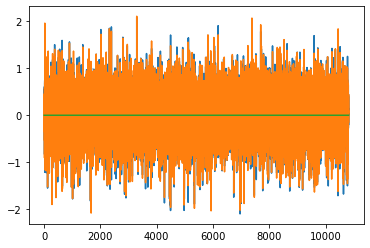

In [65]:
plt.plot(T),plt.plot(q_in),plt.plot(lbd_in)
lbd_in*dt

In [66]:
print(-lbd_in*dt)
print(np.exp(-lbd_in*dt))

[-0.21761112 -0.14258891 -0.11248719 ... -0.22001228 -0.26158679
 -0.25685901]
[0.80443821 0.86711045 0.8936088  ... 0.80250894 0.76982906 0.77347726]


In [67]:
# Prepare for spectra calculation

usesaved = False # Set to true to used loaded data from synth_stochmod_spectra



if usesaved:
    stochspec0 = [sst[model],dmp[model],frc[model]]
else:
    stochspec0 = [T,dampterm,forceterm]
stochspec = []
for varss in stochspec0: # Convert back by multiplying by rho cp h
    
    vin = varss.copy()
    vin *= (rho*cp0*mld.mean()/dt)
    stochspec.append(vin)
    print(np.var(vin))
    

stochspec[1].shape

1617.1840339643902
50.75210943569738
1572.921557364123


(10812,)

In [68]:
#Print Variance of each variable

stochvarn = ("Q","-lambda*T","q")

for v in range(len(stochspec0)):
    print("Variance(%s) is %f" % (stochvarn[v],np.var(stochspec0[v]*(rho*cp0*mld.mean()/dt))))

Variance(Q) is 40.214227
Variance(-lambda*T) is 7.124051
Variance(q) is 39.660075


In [36]:
np.var(stochspec0[v])

0.2108011372119826

In [29]:
# Calculate the spectra of each one


nsmooth = [500,500,500,500]
pct   = 0.1

stspecs,stfreqs,stCCs,stdofs,str1s = scm.quick_spectrum(stochspec,nsmooth,pct)

# Calculate associated uncertainty
alpha = 0.05
stbnds  = []
for nu in stdofs:
    lower,upper = tbx.confid(alpha,nu*2)
    stbnds.append([lower,upper])

Warning, window does not sum to 1!
Warning, window does not sum to 1!
Warning, window does not sum to 1!


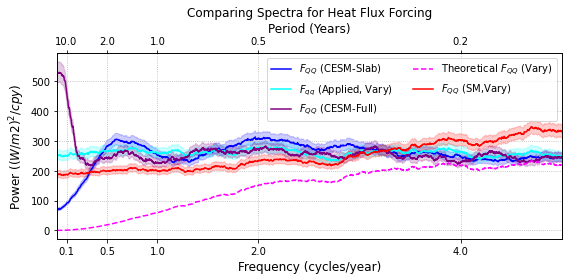

In [79]:
# Remake the Linlin, Plot, but now with the stochastic model terms

# Do a lin-lin plot

# Plot the spectra (from analysis/plot_spectra_Generals.py)

# Plotting Params
plotdt = 3600*24*365
xtick  = [1/10,1/2,1,2,4]
#ylm    = [-.01,.5]
xlm    = [5e-3,5]
titles = ("Varying Damping and Forcing (Levels 1-3)",
          "Varying Mixed-Layer Depth (Levels 3-5)")
plotconf=True

# Plotting params (SPECIFIC TO THIS SCRIPT)
nplot=len(freqs)
ecolors  = ["gray","blue","orange","cyan","purple"]
enames   = ["T","$F_{QQ}$ (CESM-Slab)","$F_{qq}$ (Applied, Const)","$F_{qq}$ (Applied, Vary)","$F_{QQ}$ (CESM-Full)"]
stcolors = ["red","green","purple"]
stnames  = ["$F_{QQ}$ (SM,Vary)","$F_{damping}$ (SM)","$F_{qq}$ (SM)"]

fig,ax = plt.subplots(1,1,figsize=(8,4))
  
for n in [1,3,4]:
    ax.plot(freqs[n]*plotdt,specs[n]/plotdt,color=ecolors[n],label=enames[n])

    if plotconf:
        lower,upper = bnds[n]
        cobj = ax.fill_between(freqs[n]*plotdt,lower*specs[n]/plotdt,
                                       upper*specs[n]/plotdt,
                                       alpha=0.20,color=ecolors[n],
                                       label="")

#ax.plot(omega*plotdt,Qth_avg/plotdt,color="r",ls='dashed',label="Theoretical $F_{QQ}$ (Const)")
ax.plot(omega*plotdt,Qth_mon/plotdt,color="magenta",ls='dashed',label="Theoretical $F_{QQ}$ (Vary)")


for n in [0]:
    ax.plot(stfreqs[n]*plotdt,stspecs[n]/plotdt,color=stcolors[n],label=stnames[n])
    
    if plotconf:
        lower,upper = stbnds[n]
        cobj = ax.fill_between(stfreqs[n]*plotdt,lower*stspecs[n]/plotdt,
                                       upper*stspecs[n]/plotdt,
                                       alpha=0.20,color=stcolors[n],
                                       label="")
    




# Set Labels
ax.set_ylabel("Power ($(W/m2)^{2} / cpy$)",fontsize=12)
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)
htax = viz.twin_freqaxis(ax,freqs[1],"Years",plotdt,mode='lin-lin',xtick=xtick)

# Set upper x-axis ticks
xtick2 = htax.get_xticks()
xtkl = ["%.1f" % (1/x) for x in xtick2]
htax.set_xticklabels(xtkl)
    
# Set axis limits
ax.set_xlim(xlm)
htax.set_xlim(xlm)
#ax.set_ylim([0,1000])
# ax.set_ylim(ylm)
# htax.set_ylim(ylm)
    
ax.legend(fontsize=10,ncol=2)
#ax.set_title(titles[i])
    
locstring= "30W, 50N"
ax.set_title("Comparing Spectra for Heat Flux Forcing")
ax.grid(True,which='both',ls='dotted')
plt.tight_layout()

plt.savefig("%sNHFLX_Spectra_Theoretical_CESM-PIC_nsmooth%i_lon-30_lat50_Ann_linlin_stochcompare.png"%(outpath,nsmooth[1]),dpi=200)


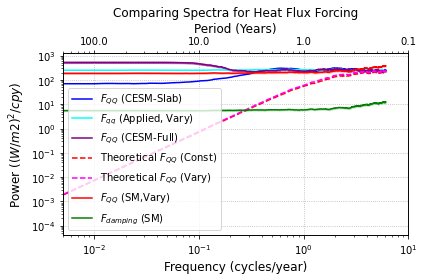

In [81]:
# Try Log log

# Do a log-log plot

# Plot the spectra (from analysis/plot_spectra_Generals.py)

# Plotting Params
plotdt = 3600*24*365
xtick  = [float(10)**(x) for x in np.arange(-4,2)]
#ylm    = [-.01,.5]
xlm    = [5e-3,10]
titles = ("Varying Damping and Forcing (Levels 1-3)",
          "Varying Mixed-Layer Depth (Levels 3-5)")
plotconf=True

# Plotting params (SPECIFIC TO THIS SCRIPT)
nplot=len(freqs)
#ecolors = ["gray","blue","orange","cyan"]
#enames = ["T","$F_{QQ}$ (CESM-Slab)","$F_{qq}$ (Applied, Const)","$F_{qq}$ (Applied, Vary)"]

fig,ax = plt.subplots(1,1,figsize=(6,4))
  
for n in [1,3,4]:
    ax.loglog(freqs[n]*plotdt,specs[n]/plotdt,color=ecolors[n],label=enames[n])

if plotconf:

    lower,upper = bnds[n]
    cobj = ax.fill_between(freqs[n]*plotdt,lower*specs[n]/plotdt,
                                   upper*specs[n]/plotdt,
                                   alpha=0.5,color=ecolors[n],
                                   label="")
    #ax.loglog(freqs[n]*plotdt,CCs[n][:,1]/plotdt,color=ecolors[n],alpha=0.5,ls='dashed')
    #ax.loglog(freqs[n]*plotdt,CCs[n][:,0]/plotdt,color=ecolors[n],alpha=0.5,ls='dotted')
    
ax.loglog(omega*plotdt,Qth_avg/plotdt,color="r",ls='dashed',label="Theoretical $F_{QQ}$ (Const)")
ax.loglog(omega*plotdt,Qth_mon/plotdt,color="magenta",ls='dashed',label="Theoretical $F_{QQ}$ (Vary)")



for n in [0,1]:
    ax.plot(stfreqs[n]*plotdt,stspecs[n]/plotdt,color=stcolors[n],label=stnames[n])
    
    if plotconf:
        lower,upper = stbnds[n]
        cobj = ax.fill_between(stfreqs[n]*plotdt,lower*stspecs[n]/plotdt,
                                       upper*stspecs[n]/plotdt,
                                       alpha=0.20,color=stcolors[n],
                                       label="")


# Set Labels
ax.set_ylabel("Power ($(W/m2)^{2} / cpy$)",fontsize=12)
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)
htax = viz.twin_freqaxis(ax,freqs[1],"Years",plotdt,mode='log-log',xtick=xtick)

# Set upper x-axis ticks
xtick2 = htax.get_xticks()
xtkl = ["%.1f" % (1/x) for x in xtick2]
htax.set_xticklabels(xtkl)
    
# Set axis limits
ax.set_xlim(xlm)
htax.set_xlim(xlm)
# ax.set_ylim(ylm)
# htax.set_ylim(ylm)
    
ax.legend(fontsize=10)
#ax.set_title(titles[i])
    
locstring= "30W, 50N"
ax.set_title("Comparing Spectra for Heat Flux Forcing")
#ax.grid(True,which='both',ls='dotted')
plt.tight_layout()

plt.savefig("%sNHFLX_Spectra_Theoretical_CESM-PIC_nsmooth%i_lon-30_lat50_Ann_loglog_stochcompare.png"%(outpath,nsmooth[1]),dpi=200)


# Check the variance of each timeseries


In [ ]:
# Print the variance of each timeseries

tscheck = []

timeprint()

In [ ]:
np.var(s)

In [19]:
(specs[1][0]*omega**2 / (omega**2+lbd_avg**2)),freqs[1],freqs[2]

(array([1.45401259e+03, 5.81603883e+03, 1.30860441e+04, ...,
        2.09293590e+09, 2.09297407e+09, 2.09301222e+09]),
 array([3.56828033e-11, 7.13656066e-11, 1.07048410e-10, ...,
        1.92829869e-07, 1.92865552e-07, 1.92901235e-07]),
 array([3.56828033e-11, 7.13656066e-11, 1.07048410e-10, ...,
        1.92829869e-07, 1.92865552e-07, 1.92901235e-07]))

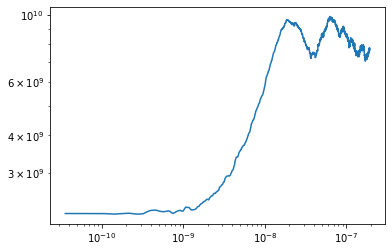

In [31]:
plt.loglog(freqs[1],specs[1])

In [109]:
%%time
# Load in data for Qnet, CESM-FULL
Qfull   = np.load(datpath+"NHFLX_PIC_Full.npy")

klon360,_ = proc.find_latlon(lonf+360,latf,lon36,lat)
Qfull.shape, plt.pcolormesh(Qfull[0,0,:,:]),plt.colorbar()

Qfullpt = Qfull[:,:,klat,klon360]

Qafullpt = Qfullpt - Qfullpt.mean(0)[None,:]

#dfpt = df.sel(lon=330,lat=50,method='nearest')
#Qfull  = dfpt.NHFLX.values
#dfpt

CPU times: user 0 ns, sys: 4.11 s, total: 4.11 s
Wall time: 4.11 s


Closest lon to 330.00 was 330.00
Closest lat to 50.00 was 50.42


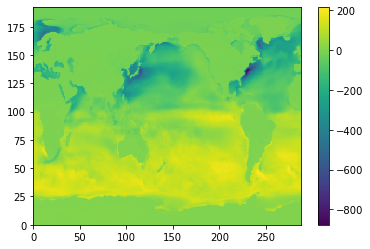

array([ 1.2762396e-04, -6.1751074e-05,  1.6184398e-05, -2.7196397e-06,
       -5.5240034e-05,  5.0982657e-05,  6.2293308e-05, -2.2282407e-05,
        1.5144412e-05,  1.9473808e-05, -1.2043514e-05,  4.6810001e-06],
      dtype=float32)